In [1]:
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [3]:
%load_ext rpy2.ipython

In [4]:
%R library(lme4)

R[write to console]: Loading required package: Matrix



'lme4','Matrix','tools',...,'datasets','methods','base'


In [5]:
# Load the data from ../analysis/ENZYMES/graphs_{i}.npy
# where i is the index of the graph
def load_data(i, model:str):
    return np.load(f'../analysis/emp-{model}-nci/NCI1/graphs_{i}.npy', allow_pickle=True)

In [6]:
def get_cna_metrics(name:str):

    # list of graph metrics for each dataset
    all_graph_metrics = []
    datasets = [load_data(i, name) for i in range(54)]
    
    for dataset in datasets:
        graph_metrics = []
        for graph in dataset:
            graph_metrics.append([
                                  graph.number_of_nodes(),
                                  nx.graph_number_of_cliques(graph),
                                  max(dict(graph.degree).values()),
                                  min(dict(graph.degree).values()),
                                  np.mean(list(dict(graph.degree).values())),
                                  #nx.degree_assortativity_coefficient(graph),
                                  nx.density(graph),
                                  np.mean(list(dict(graph.degree).values())),
                                  nx.average_clustering(graph),
                                  graph.graph['graph_id'],
                                  graph.graph['prediction'],
                                  graph.graph['label'],
                                  graph.graph['softmax'],
                                  graph.graph['correct'],
                                  graph.graph['loss'],
                                  "HGP-SL",
                                  "NCI1",
                                  graph.graph['random_seed'],
                                  graph.graph['dropout_ratio'],
                                  graph.graph['pooling_ratio'],
                                  graph.graph['structure_learning'],
                                  graph.graph['sigmod'],
                                  ])
        all_graph_metrics.append(graph_metrics)
    
    return all_graph_metrics

In [7]:
def rename_columns(df):
    # maps the index of graph_metrics to the metric name (needed to label automatically in visualization)
    index_to_metric = {
                        0: 'Number_of_Vertices',
                        1: 'Number_of_Cliques',
                        2: 'Maximum_Degree',
                        3: 'Minimum_Degree',
                        4: 'Average_Degree',
                        5: 'Density',
                        6: 'Average_Neighbor_Degree',
                        7: 'Average_Clustering_Coefficient',
                        8: 'Graph_ID',
                        9: 'Prediction',
                        10: 'Label',
                        11: 'Confidence',
                        12: 'Correct',
                        13: 'Loss',
                        14: 'Architecture',
                        15: 'Dataset',
                        16: 'Random_Seed',
                        17: 'Dropout_Ratio',
                        18: 'Pooling_Ratio',
                        19: 'Structure_Learning',
                        20: 'Sigmoid',
                       }

    df = df.rename(columns=index_to_metric)
    return df

In [8]:
# build a dataframe for each dataset
def build_dataframe(all_graph_metrics):
    df_list = []
    for graph_metrics in all_graph_metrics:
        df = pd.DataFrame(graph_metrics)
        df = rename_columns(df)
        df_list.append(df)
    return df_list

In [9]:
df_list_hgp = build_dataframe(get_cna_metrics("hgp"))
df_list_gcn = build_dataframe(get_cna_metrics("gcn"))

In [10]:
# concatenate the dataframes
df_hgp = pd.concat(df_list_hgp, ignore_index=True)
df_gcn = pd.concat(df_list_gcn, ignore_index=True)

In [13]:
df_hgp[df_hgp.Structure_Learning == "True"].shape

(27756, 21)

In [12]:
df_gcn.Loss

0        0.670692
1        0.630860
2        0.539649
3        1.544158
4        0.744238
           ...   
55507    1.278697
55508    0.402030
55509    0.212523
55510    1.123517
55511    0.324139
Name: Loss, Length: 55512, dtype: float64

In [13]:
import matplotlib.pyplot as plt

In [35]:
# Create a scatterplot of the data with the regression line and confidence interval
def plot_scatterplot(df, x, y, title, xlabel, ylabel, save_path):

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot the data
    ax.scatter(df[x], df[y], s=10, c='b', alpha=0.5)
    
    # Calculate the trendline
    z = np.polyfit(df[x], df[y], 1)

    # Plot the regression line
    p = np.poly1d(z)
    ax.plot(df[x], p(df[x]), "r--")
    #ax.plot(df[x], m*x, c='b', alpha=0.5)

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

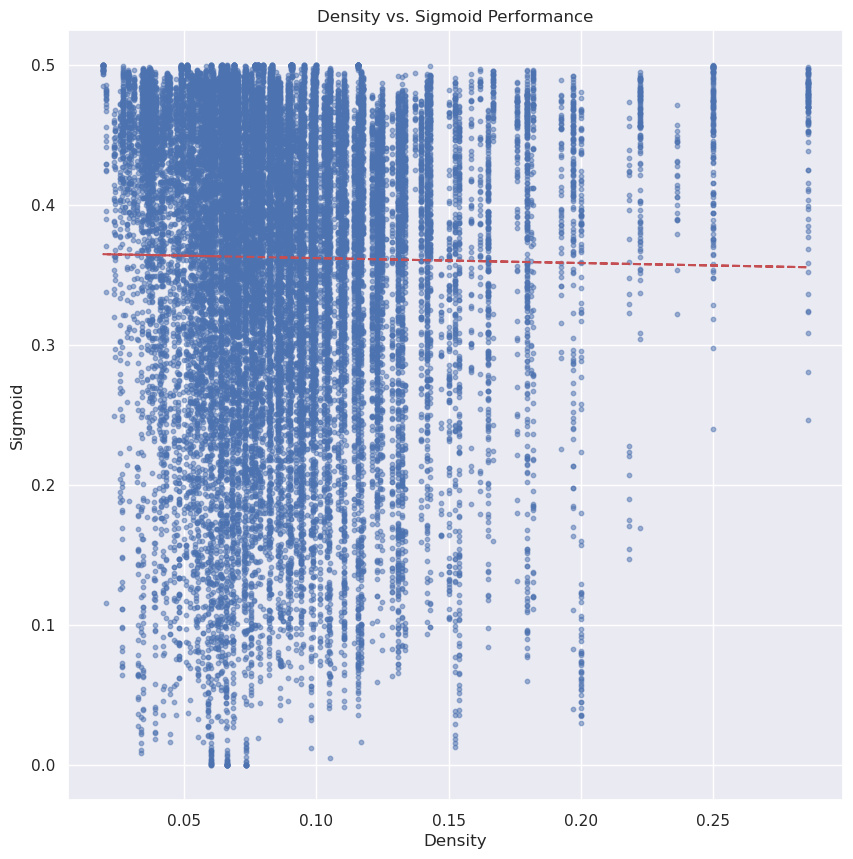

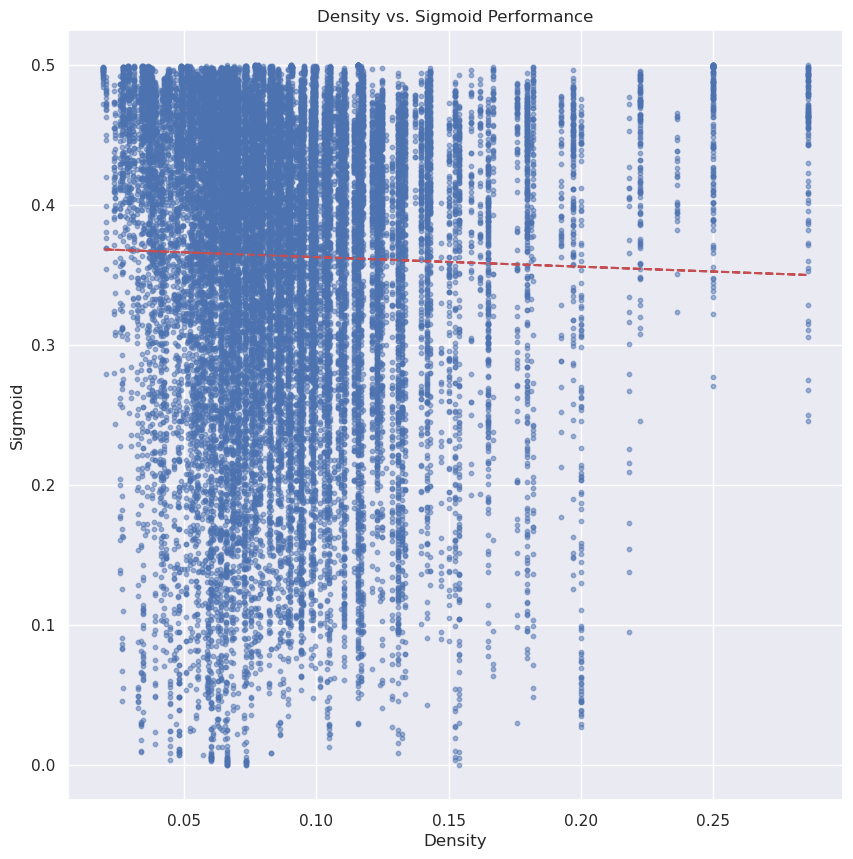

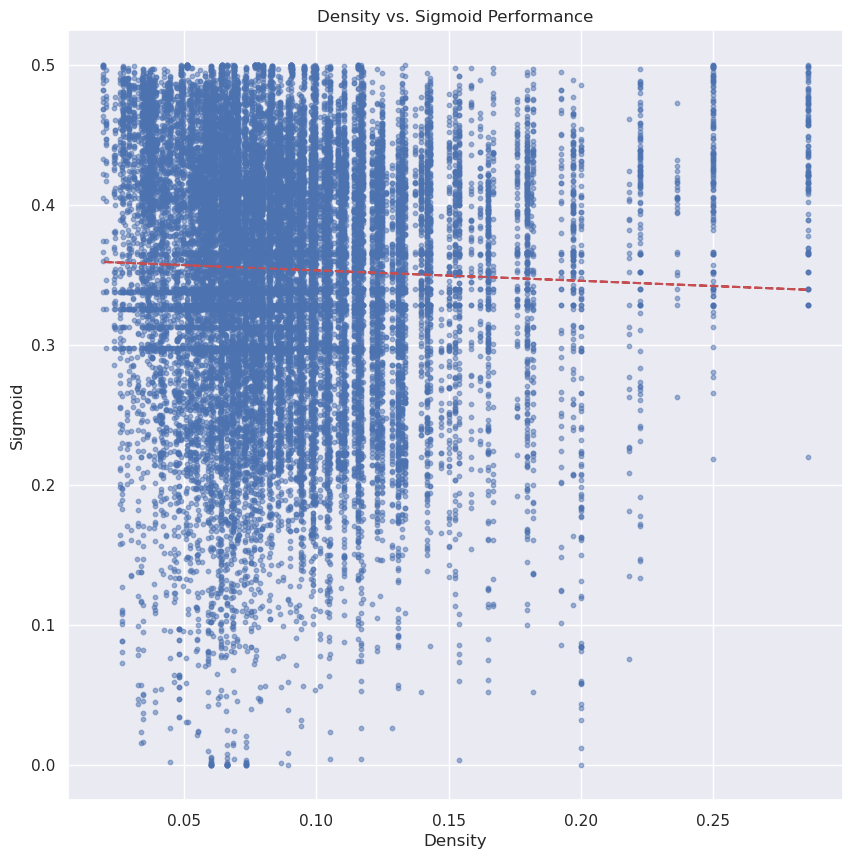

In [37]:
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "False"], 'Density', 'Sigmoid', 'Density vs. Sigmoid Performance', 'Density', 'Sigmoid', 'all_hgp_density_vs_sigmoid_nosl.png')
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "True"], 'Density', 'Sigmoid', 'Density vs. Sigmoid Performance', 'Density', 'Sigmoid', 'all_hgp_density_vs_sigmoid_withsl.png')
plot_scatterplot(df_gcn[df_gcn.Structure_Learning == "False"], 'Density', 'Sigmoid', 'Density vs. Sigmoid Performance', 'Density', 'Sigmoid', 'all_gcn_density_vs_sigmoid.png')

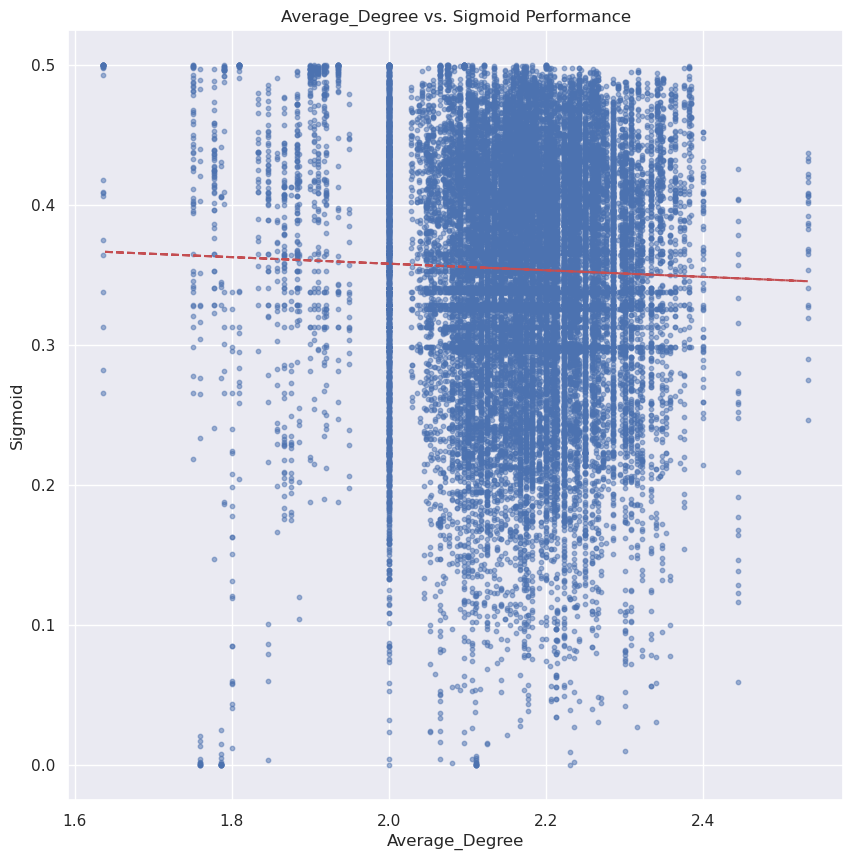

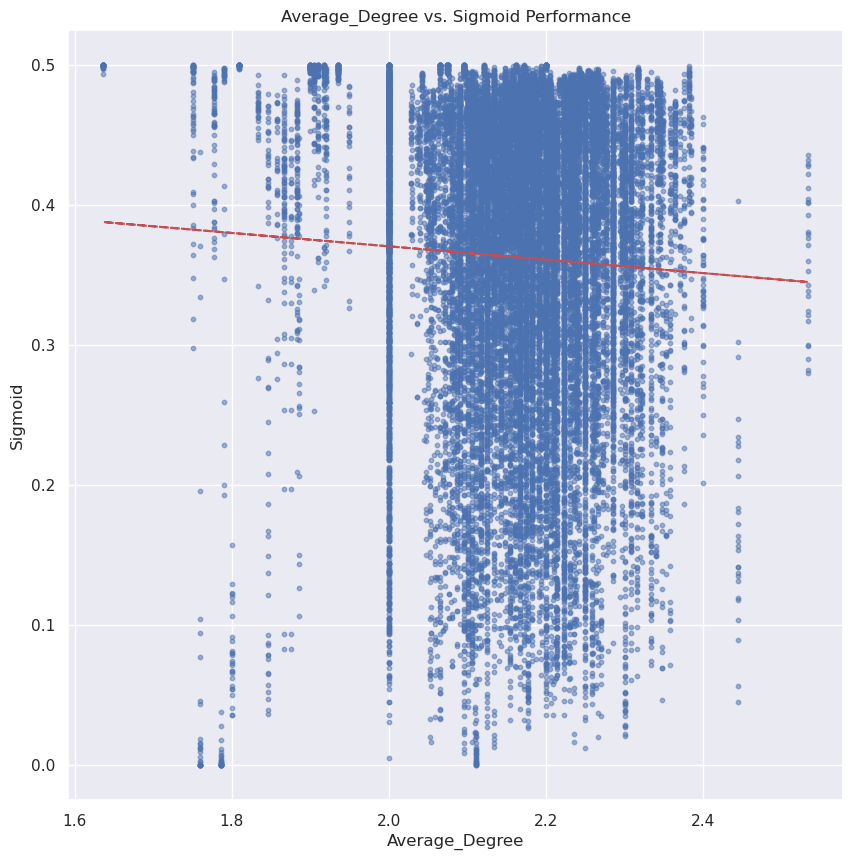

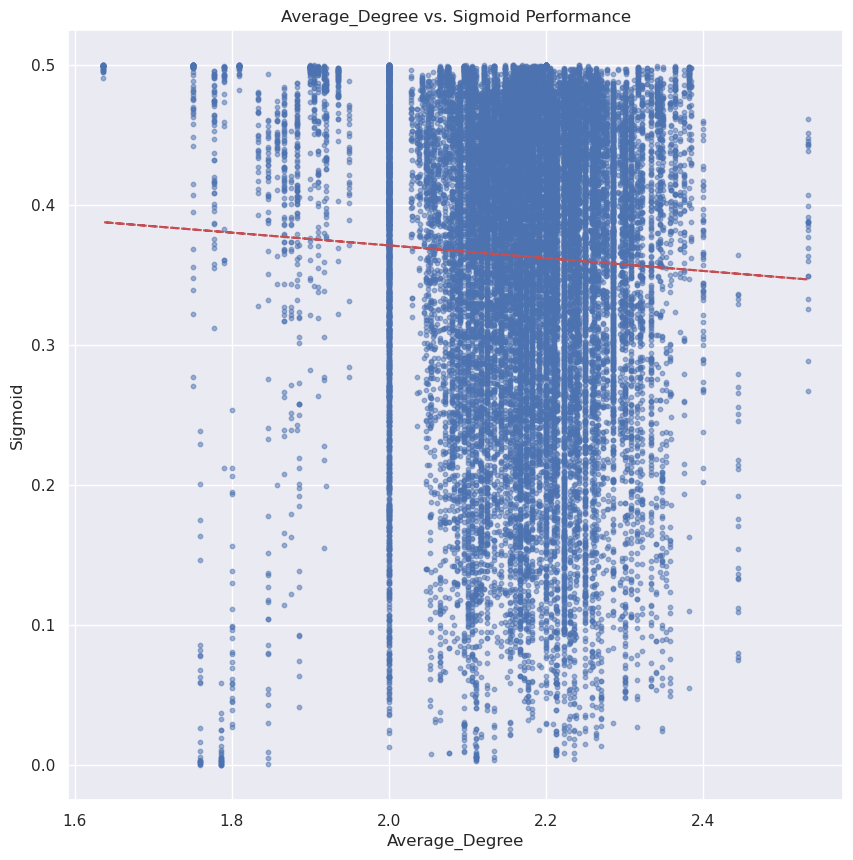

In [38]:
plot_scatterplot(df_gcn[df_gcn.Structure_Learning == "False"], 'Average_Degree', 'Sigmoid', 'Average_Degree vs. Sigmoid Performance', 'Average_Degree', 'Sigmoid', 'all_gcn_average_degree_vs_sigmoid.png')
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "False"], 'Average_Degree', 'Sigmoid', 'Average_Degree vs. Sigmoid Performance', 'Average_Degree', 'Sigmoid', 'all_hgp_average_degree_vs_sigmoid_nosl.png')
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "True"], 'Average_Degree', 'Sigmoid', 'Average_Degree vs. Sigmoid Performance', 'Average_Degree', 'Sigmoid', 'all_hgp_average_degree_vs_sigmoid_withsl.png')

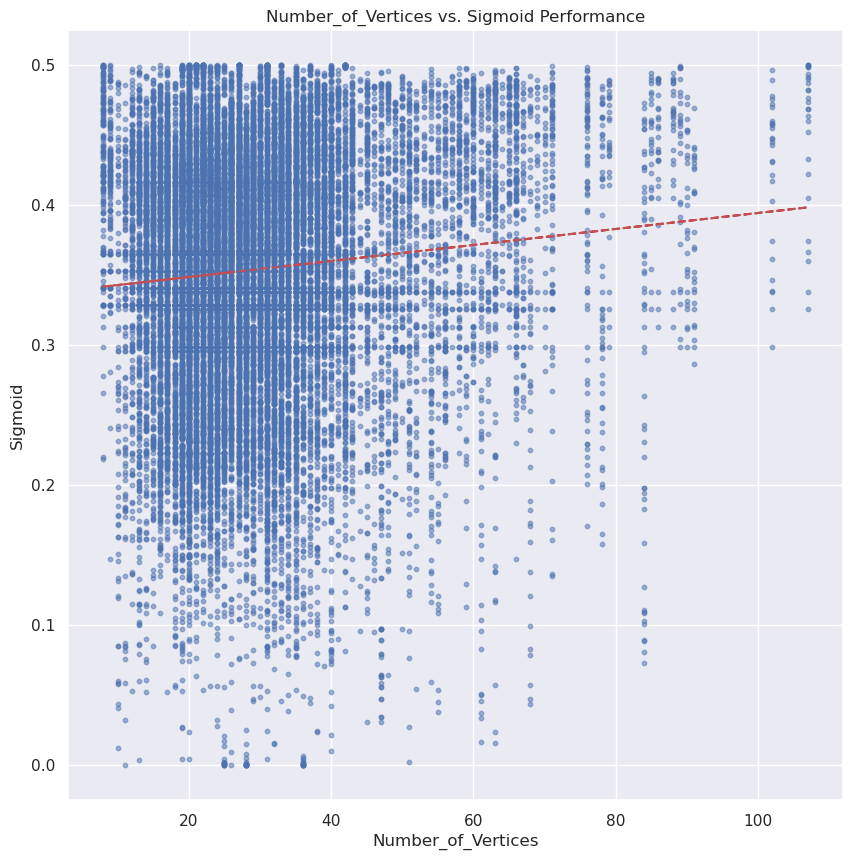

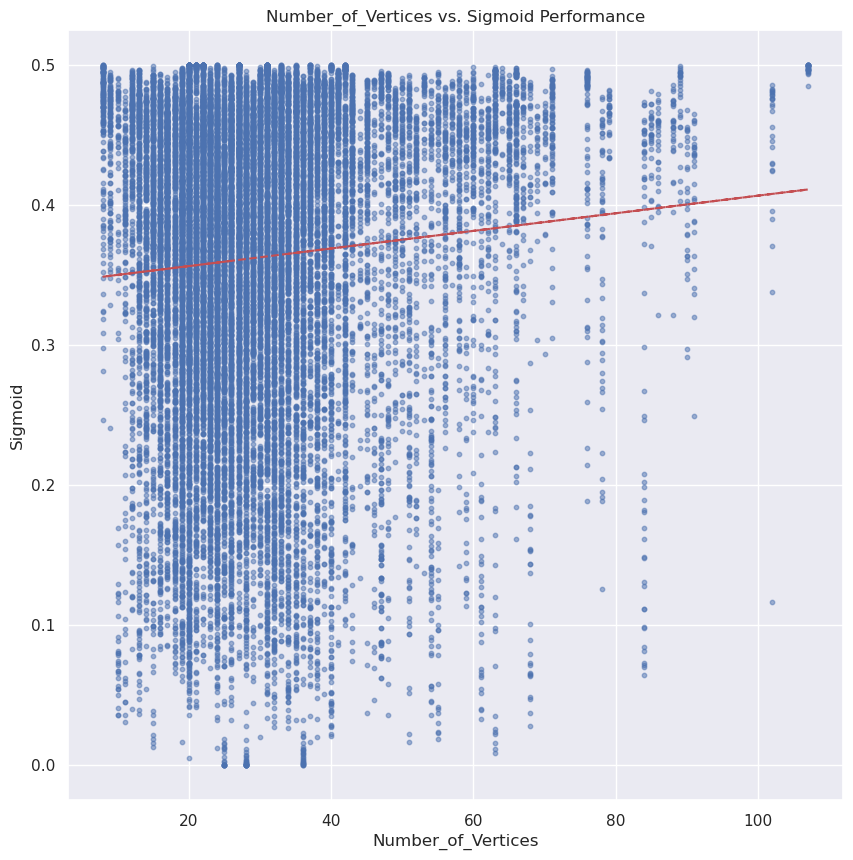

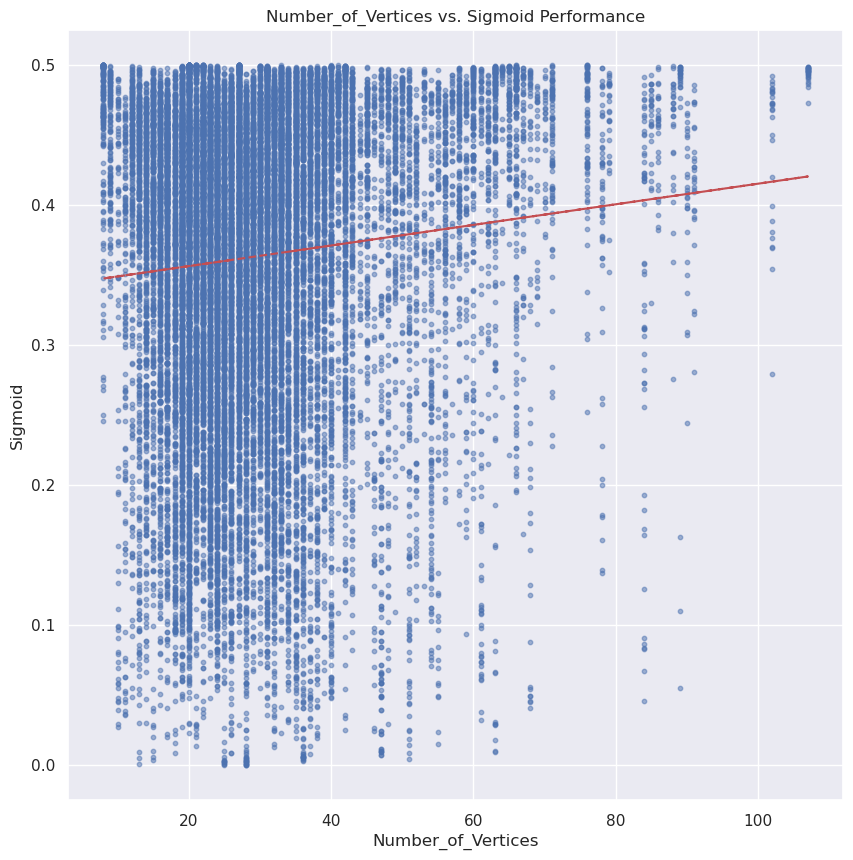

In [39]:
plot_scatterplot(df_gcn[df_gcn.Structure_Learning == "False"], 'Number_of_Vertices', 'Sigmoid', 'Number_of_Vertices vs. Sigmoid Performance', 'Number_of_Vertices', 'Sigmoid', 'all_gcn_number_of_vertices_vs_sigmoid.png')
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "False"], 'Number_of_Vertices', 'Sigmoid', 'Number_of_Vertices vs. Sigmoid Performance', 'Number_of_Vertices', 'Sigmoid', 'all_hgp_number_of_vertices_vs_sigmoid_nosl.png')
plot_scatterplot(df_hgp[df_hgp.Structure_Learning == "True"], 'Number_of_Vertices', 'Sigmoid', 'Number_of_Vertices vs. Sigmoid Performance', 'Number_of_Vertices', 'Sigmoid', 'all_hgp_number_of_vertices_vs_sigmoid_withsl.png')

In [53]:
eval_data = df_hgp.assign(Number_of_Vertices_class = lambda x: pd.cut(x.Number_of_Vertices, bins=[np.min(x.Number_of_Vertices), 20, 40, np.max(x.Number_of_Vertices)], labels=["small", "typical", "very large"], include_lowest=True))

In [54]:
eval_data

,Number_of_Vertices,Number_of_Cliques,Maximum_Degree,Minimum_Degree,Average_Degree,Density,Average_Neighbor_Degree,Average_Clustering_Coefficient,Graph_ID,Prediction,...,Correct,Loss,Architecture,Dataset,Random_Seed,Dropout_Ratio,Pooling_Ratio,Structure_Learning,Sigmoid,Number_of_Vertices_class
0,26,28,3,1,2.153846,0.086154,2.153846,0.00,0,1,...,True,0.456532,HGP-SL,NCI1,21,0,0.1,True,0.387809,typical
1,21,21,3,1,2.000000,0.100000,2.000000,0.00,1,1,...,False,0.937766,HGP-SL,NCI1,21,0,0.1,True,0.281352,typical
2,49,51,4,1,2.081633,0.043367,2.081633,0.00,2,1,...,True,0.394406,HGP-SL,NCI1,21,0,0.1,True,0.402657,very large
3,61,63,4,1,2.065574,0.034426,2.065574,0.00,3,1,...,False,1.569685,HGP-SL,NCI1,21,0,0.1,True,0.172261,very large
4,28,31,3,1,2.214286,0.082011,2.214286,0.00,4,0,...,True,0.433430,HGP-SL,NCI1,21,0,0.1,True,0.393308,typical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55507,29,30,4,1,2.068966,0.073892,2.068966,0.00,1023,0,...,True,0.167140,HGP-SL,NCI1,2021,0.3,0.5,False,0.458312,typical
55508,25,26,4,1,2.240000,0.093333,2.240000,0.04,1024,1,...,True,0.426263,HGP-SL,NCI1,2021,0.3,0.5,False,0.395019,typical
55509,23,27,4,1,2.347826,0.106719,2.347826,0.00,1025,0,...,True,0.252785,HGP-SL,NCI1,2021,0.3,0.5,False,0.437138,typical
55510,19,21,4,1,2.210526,0.122807,2.210526,0.00,1026,0,...,True,0.589058,HGP-SL,NCI1,2021,0.3,0.5,False,0.356851,small


In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import VCSpec
import pandas as pd

In [18]:
"""
Local Regression (LOESS) estimation routine.
"""
import numpy as np
import pandas as pd
import scipy


def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

In [19]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def para_plot(save_path:str, x:str, y:str, df):
    sns.set(context='notebook', style='darkgrid', font_scale=1)

    np.random.seed(16)

    xvals = df[x]

    yvals = df[y]

    regsDF, evalDF = loess(xvals, yvals, alpha=.6, poly_degree=1)

    # Obtain reference to LOESS x & y values (v & g).
    l_x  = evalDF['v'].values
    l_y  = evalDF['g'].values

    # Generate x-y scatterplot with loess estimate overlaid.
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.grid(True)
    ax1.minorticks_on()
    ax1.scatter(xvals, yvals, label="Original Data")
    ax1.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
    ax1.set_title("Linear LOESS Estimator", loc="left", fontsize=14)
    ax1.legend(loc="upper left",
            scatterpoints=1,
            fontsize=11,
            frameon=True,
            fancybox=True,
            facecolor="#FFFFFF",
            edgecolor="#000000")
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
df_hgp[df_hgp.Structure_Learning == "False"].shape

(27756, 21)

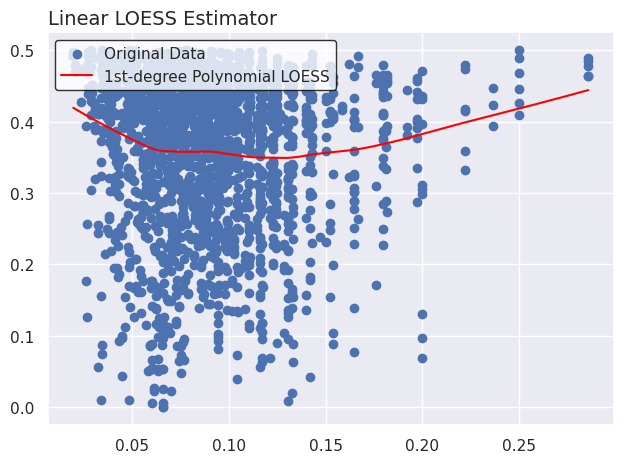

In [77]:
para_plot(save_path = 'hgpsl_density_vs_loss.png', x="Density", y="Sigmoid", df=df_hgp[(df_hgp.Structure_Learning == "True")].sample(n=2000, random_state=42))

In [ ]:
md = smf.mixedlm("Loss ~ (1 | Pooling_Ratio)", df, groups=df["Pooling_Ratio"], re_formula="~Pooling_Ratio")
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(3), np.eye(3)
)
mdf = md.fit(free=free, method=["lbfgs"])
print(mdf.summary())

In [ ]:
mdf.summary()

In [48]:
np.percentile(df_hgp.Density, 75)

0.10977443609022557

In [11]:
eval_hgp = df_hgp.assign(Density_class = lambda x: pd.cut(x.Density, bins=[np.min(x.Density), 0.065, 0.11, np.max(x.Density)], labels=["sparse", "typical", "dense"], include_lowest=True))
eval_gcn = df_gcn.assign(Density_class = lambda x: pd.cut(x.Density, bins=[np.min(x.Density), 0.065, 0.11, np.max(x.Density)], labels=["sparse", "typical", "dense"], include_lowest=True))

In [12]:
eval_hgpsl = eval_hgp[eval_hgp.Structure_Learning == "True"]
eval_hgp = eval_hgp[eval_hgp.Structure_Learning == "False"]
eval_gcn = eval_gcn[eval_gcn.Structure_Learning == "False"]

In [59]:
df

,Number_of_Vertices,Number_of_Cliques,Maximum_Degree,Minimum_Degree,Average_Degree,Density,Average_Neighbor_Degree,Average_Clustering_Coefficient,Graph_ID,Prediction,...,Correct,Loss,Architecture,Dataset,Random_Seed,Dropout_Ratio,Pooling_Ratio,Structure_Learning,Sigmoid,Density_class
0,26,28,3,1,2.153846,0.086154,2.153846,0.00,0,1,...,True,0.456532,HGP-SL,NCI1,21,0,0.1,True,0.387809,typical
1,21,21,3,1,2.000000,0.100000,2.000000,0.00,1,1,...,False,0.937766,HGP-SL,NCI1,21,0,0.1,True,0.281352,typical
2,49,51,4,1,2.081633,0.043367,2.081633,0.00,2,1,...,True,0.394406,HGP-SL,NCI1,21,0,0.1,True,0.402657,sparse
3,61,63,4,1,2.065574,0.034426,2.065574,0.00,3,1,...,False,1.569685,HGP-SL,NCI1,21,0,0.1,True,0.172261,sparse
4,28,31,3,1,2.214286,0.082011,2.214286,0.00,4,0,...,True,0.433430,HGP-SL,NCI1,21,0,0.1,True,0.393308,typical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54479,29,30,4,1,2.068966,0.073892,2.068966,0.00,1023,1,...,False,0.793326,HGP-SL,NCI1,2021,0.3,0.5,True,0.311455,typical
54480,25,26,4,1,2.240000,0.093333,2.240000,0.04,1024,1,...,True,0.424709,HGP-SL,NCI1,2021,0.3,0.5,True,0.395390,typical
54481,23,27,4,1,2.347826,0.106719,2.347826,0.00,1025,0,...,True,0.212226,HGP-SL,NCI1,2021,0.3,0.5,True,0.447142,typical
54482,19,21,4,1,2.210526,0.122807,2.210526,0.00,1026,0,...,True,0.264168,HGP-SL,NCI1,2021,0.3,0.5,True,0.434340,dense


In [60]:
from matplotlib.transforms import Affine2D

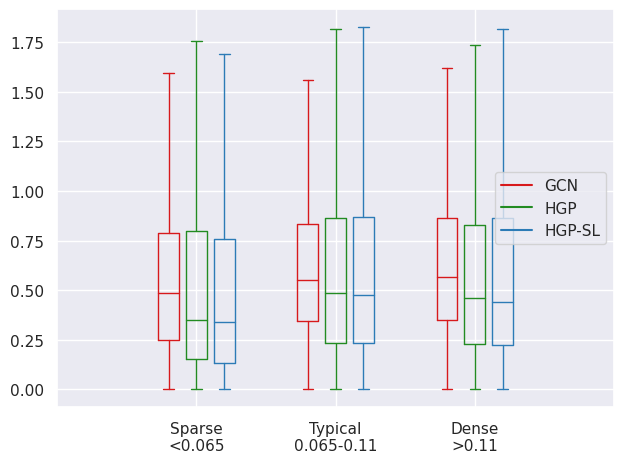

In [74]:
import matplotlib.pyplot as plt
import numpy as np

gcn_boxes = [eval_gcn[eval_gcn.Density_class == "sparse"].Loss, eval_gcn[eval_gcn.Density_class == "typical"].Loss, eval_gcn[eval_gcn.Density_class == "dense"].Loss]
hgp_boxes = [eval_hgp[eval_hgp.Density_class == "sparse"].Loss, eval_hgp[eval_hgp.Density_class == "typical"].Loss, eval_hgp[eval_hgp.Density_class == "dense"].Loss]
hgpsl_boxes = [eval_hgpsl[eval_hgpsl.Density_class == "sparse"].Loss, eval_hgpsl[eval_hgpsl.Density_class == "typical"].Loss, eval_hgpsl[eval_hgpsl.Density_class == "dense"].Loss]

ticks = ["""Sparse\n<0.065""", """Typical\n0.065-0.11""", """Dense\n>0.11"""]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(gcn_boxes, positions=np.array(range(len(gcn_boxes)))*2.0-0.4, sym='', widths=0.3)
bpm = plt.boxplot(hgp_boxes, positions=np.array(range(len(hgp_boxes)))*2.0, sym='', widths=0.3)
bpr = plt.boxplot(hgpsl_boxes, positions=np.array(range(len(hgpsl_boxes)))*2.0+0.4, sym='', widths=0.3)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpm, '#228B22')
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='GCN')
plt.plot([], c='#228B22', label='HGP')
plt.plot([], c='#2C7BB6', label='HGP-SL')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
#plt.savefig('boxcompare.png')

In [13]:
hgpsl_filter = eval_hgpsl[["Graph_ID", "Density", "Density_class", "Sigmoid", "Loss"]]
hgpsl_filter["system"] = "HGP-SL"

/tmp/ipykernel_18281/1034956159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hgpsl_filter["system"] = "HGP-SL"


In [14]:
hgp_filter = eval_hgp[["Graph_ID", "Density", "Density_class", "Sigmoid", "Loss"]]
hgp_filter["system"] = "HGP"

/tmp/ipykernel_18281/1696885762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hgp_filter["system"] = "HGP"


In [15]:
gcn_filter = eval_hgp[["Graph_ID", "Density", "Density_class", "Sigmoid", "Loss"]]
gcn_filter["system"] = "GCN"

/tmp/ipykernel_18281/1690465711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcn_filter["system"] = "GCN"


In [16]:
dataframe = pd.concat([gcn_filter, hgp_filter, hgpsl_filter], ignore_index=True)

In [17]:
dataframe

,Graph_ID,Density,Density_class,Sigmoid,Loss,system
0,0,0.086154,typical,0.341999,0.654397,GCN
1,1,0.100000,typical,0.281530,0.936886,GCN
2,2,0.043367,sparse,0.413324,0.350241,GCN
3,3,0.034426,sparse,0.191186,1.442322,GCN
4,4,0.082011,typical,0.393381,0.433124,GCN
...,...,...,...,...,...,...
83263,1023,0.073892,typical,0.311455,0.793326,HGP-SL
83264,1024,0.093333,typical,0.395390,0.424709,HGP-SL
83265,1025,0.106719,typical,0.447142,0.212226,HGP-SL
83266,1026,0.122807,dense,0.434340,0.264168,HGP-SL


In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from pymer4.models import Lmer # just import the linear mixed models class 
import scipy.stats as stats 

In [ ]:
model_nointeraction = Lmer("Sigmoid ~ system + Density_class (1 | Graph_ID)", data = dataframe)
model_nointeraction.fit(factors = {"system" : ["GCN", "HGP", "HGP-SL"], "Density_class" : ["sparse", "typical", "dense"]})

In [22]:
data = dataframe
md = smf.mixedlm("Sigmoid ~ system + Density_class  + system:Density_class", data, groups=data["Graph_ID"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/home/bjoern/miniconda3/envs/pymer4/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Sigmoid    
No. Observations:          83268            Method:                      REML       
No. Groups:                1028             Scale:                       0.0048     
Min. group size:           81               Log-Likelihood:              101240.1851
Max. group size:           81               Converged:                   Yes        
Mean group size:           81.0                                                     
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.373    0.005 72.468 0.000  0.363  0.383
system[T.HGP]                             -0.000    0.001 -0.000 1.000 -0.002  0.002
syst

In [23]:
data = dataframe
md2 = smf.mixedlm("Sigmoid ~ system + Density_class", data, groups=data["Graph_ID"])
mdf2 = md2.fit(method=["lbfgs"])
print(mdf2.summary())

/home/bjoern/miniconda3/envs/pymer4/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Sigmoid    
No. Observations:     83268      Method:                REML       
No. Groups:           1028       Scale:                 0.0048     
Min. group size:      81         Log-Likelihood:        101259.9991
Max. group size:      81         Converged:             Yes        
Mean group size:      81.0                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.374    0.005 73.082 0.000  0.364  0.384
system[T.HGP]            -0.000    0.001 -0.000 1.000 -0.001  0.001
system[T.HGP-SL]          0.001    0.001  1.798 0.072 -0.000  0.002
Density_class[T.typical] -0.016    0.006 -2.495 0.013 -0.028 -0.003
Density_class[T.dense]   -0.014    0.007 -1.956 0.050 -0.028  0

In [37]:
def GLRT(mod1, mod2):
    
    chi_square = 2 * abs(mod1.llf - mod2.llf)
    delta_params = abs(len(mod1.fe_params) - len(mod2.fe_params)) 
    
    return {"chi_square" : chi_square, "df": delta_params, "p" : 1 - stats.chi2.cdf(chi_square, df=delta_params)}

In [38]:
GLRT(mdf, mdf2)

{'chi_square': 39.6280577420257, 'df': 4, 'p': 5.16693204888341e-08}

In [36]:
mdf.fe_params

Intercept                                    3.731606e-01
system[T.HGP]                               -1.654631e-15
system[T.HGP-SL]                             3.238380e-03
Density_class[T.typical]                    -1.468186e-02
Density_class[T.dense]                      -1.321281e-02
system[T.HGP]:Density_class[T.typical]       1.725774e-15
system[T.HGP-SL]:Density_class[T.typical]   -2.925925e-03
system[T.HGP]:Density_class[T.dense]         1.621946e-15
system[T.HGP-SL]:Density_class[T.dense]     -2.896620e-03
dtype: float64

In [39]:
data = dataframe[dataframe.system != "GCN"]
md3 = smf.mixedlm("Sigmoid ~ system + Density_class  + system:Density_class", data, groups=data["Graph_ID"])
mdf3 = md.fit(method=["lbfgs"])
print(mdf3.summary())

/home/bjoern/miniconda3/envs/pymer4/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Sigmoid    
No. Observations:          83268            Method:                      REML       
No. Groups:                1028             Scale:                       0.0048     
Min. group size:           81               Log-Likelihood:              101240.1851
Max. group size:           81               Converged:                   Yes        
Mean group size:           81.0                                                     
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.373    0.005 72.468 0.000  0.363  0.383
system[T.HGP]                             -0.000    0.001 -0.000 1.000 -0.002  0.002
syst

In [40]:
data = dataframe[dataframe.system != "GCN"]
md4 = smf.mixedlm("Sigmoid ~ system + Density_class", data, groups=data["Graph_ID"])
mdf4 = md4.fit(method=["lbfgs"])
print(mdf4.summary())

/home/bjoern/miniconda3/envs/pymer4/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Sigmoid   
No. Observations:      55512      Method:                REML      
No. Groups:            1028       Scale:                 0.0050    
Min. group size:       54         Log-Likelihood:        66026.7282
Max. group size:       54         Converged:             Yes       
Mean group size:       54.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.374    0.005 73.610 0.000  0.364  0.384
system[T.HGP-SL]          0.001    0.001  1.769 0.077 -0.000  0.002
Density_class[T.typical] -0.016    0.006 -2.587 0.010 -0.028 -0.004
Density_class[T.dense]   -0.015    0.007 -2.035 0.042 -0.029 -0.001
Group Var                 0.007    0.004                       

In [41]:
GLRT(mdf3, mdf4)

{'chi_square': 70426.9138944418, 'df': 5, 'p': 0.0}